### Stpes
1. 필수 라이브러리를 가져오고 주어진 CSV를 데이터프레임으로 읽은 후 작업 수행
* 데이터 프레임의 일부 관측치와 shape를 확인.
* 결측값이 있는지 확인후, 보완
  
* 단변량 분석
* 이변량 분석
* 관련 없는 열 삭제
2. 데이터를 표준화
3. 종송 열("Pass/Fail")을 데이터 프레임에서 분리후, 훈련 세트와 테스트 세트로 분리
4. 로지스틱 회귀, 랜덤 포레스트, XGBoost 분류기 모델을 구축후 혼동 행렬을 출력
5. 불균형 클래스 문제를 해결하기 위한 샘플링 기법을 적용
6. 데이터 재 샘플링 후, 다시 분류기 모델을 구축후 혼동 행렬을 출력
7. Grid  Search CV를 사용하여 위 모델 중 하나의 최적 하이퍼파라미터를 찾음
8. 최적 하이퍼파라미터를 사용하여 분류기 모델을 구축하고 정확도와 혼동 행렬을 확인
9. 결과 및 분석 내용을 보고

In [19]:
# https://www.kaggle.com/code/saurabhbagchi/fmst-semiconductor-manufacturing-project/notebook
# 기본 작동을 위한 패키지
import numpy as np
import pandas as pd

# 시각화를 위한 패키지
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# 모델링을 위한 패키지
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM
from sklearn.metrics import recall_score

# 오류 방지
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Jupyter Notebook에서 출력 억제
from IPython.display import display

# 패치 제공
import os
print(os.listdir("."))



['.DS_Store', 'Semiconductor_manufacturing_project.ipynb', 'task', '.ipynb_checkpoints', 'uci-secom.csv']


# Reading the Data set and understanding the atributes

In [20]:
#데이터 불러오기
data = pd.read_csv('./uci-secom.csv')

#shape of the data
# 1567개의 행 592개의 컬럼
print(data.shape)

(1567, 592)


In [21]:
# head of the data
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [22]:
#위 데이터셋에 NaN의 값이 있으므로 결측값을 보완한다.
data.isnull().any().any()
# Ture가 나오면 결측값이 있다는 의미

True

In [23]:
# 모든 결측치를 0으로 치환한다.
# 값이 존재하지 않음은 사용이나 계산이 불가능함을 의미
# NaN의 값은 데이터 셋에 신호가 없다는 의미로 가정함.
# 즉, NaN의 값은 테스트 데이터의 부재를 나타내며,
# 이는 '신호 없음' 으로 간주된다.
# 일반적으로 결측값은 평균값이나 중앙값으로 치환하지만
# 이 데이터셋의 경우 0으로 치환이 더 적절하다고 판단.

data = data.replace(np.NaN, 0)

# 다시 한번 결측치의 검사 
# Ture가 나오면 존재함
# False가 나오면 존재하지 않음
data.isnull().any().any()

False

# Data Visualization

In [24]:
unique_vals = data['Pass/Fail'].unique() 
# Pass/Fail의 값은 -1 , 1만 나옴
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]
# Pass/Fail의 값이 -1 또는 1인 행들을 리스트로 반환함

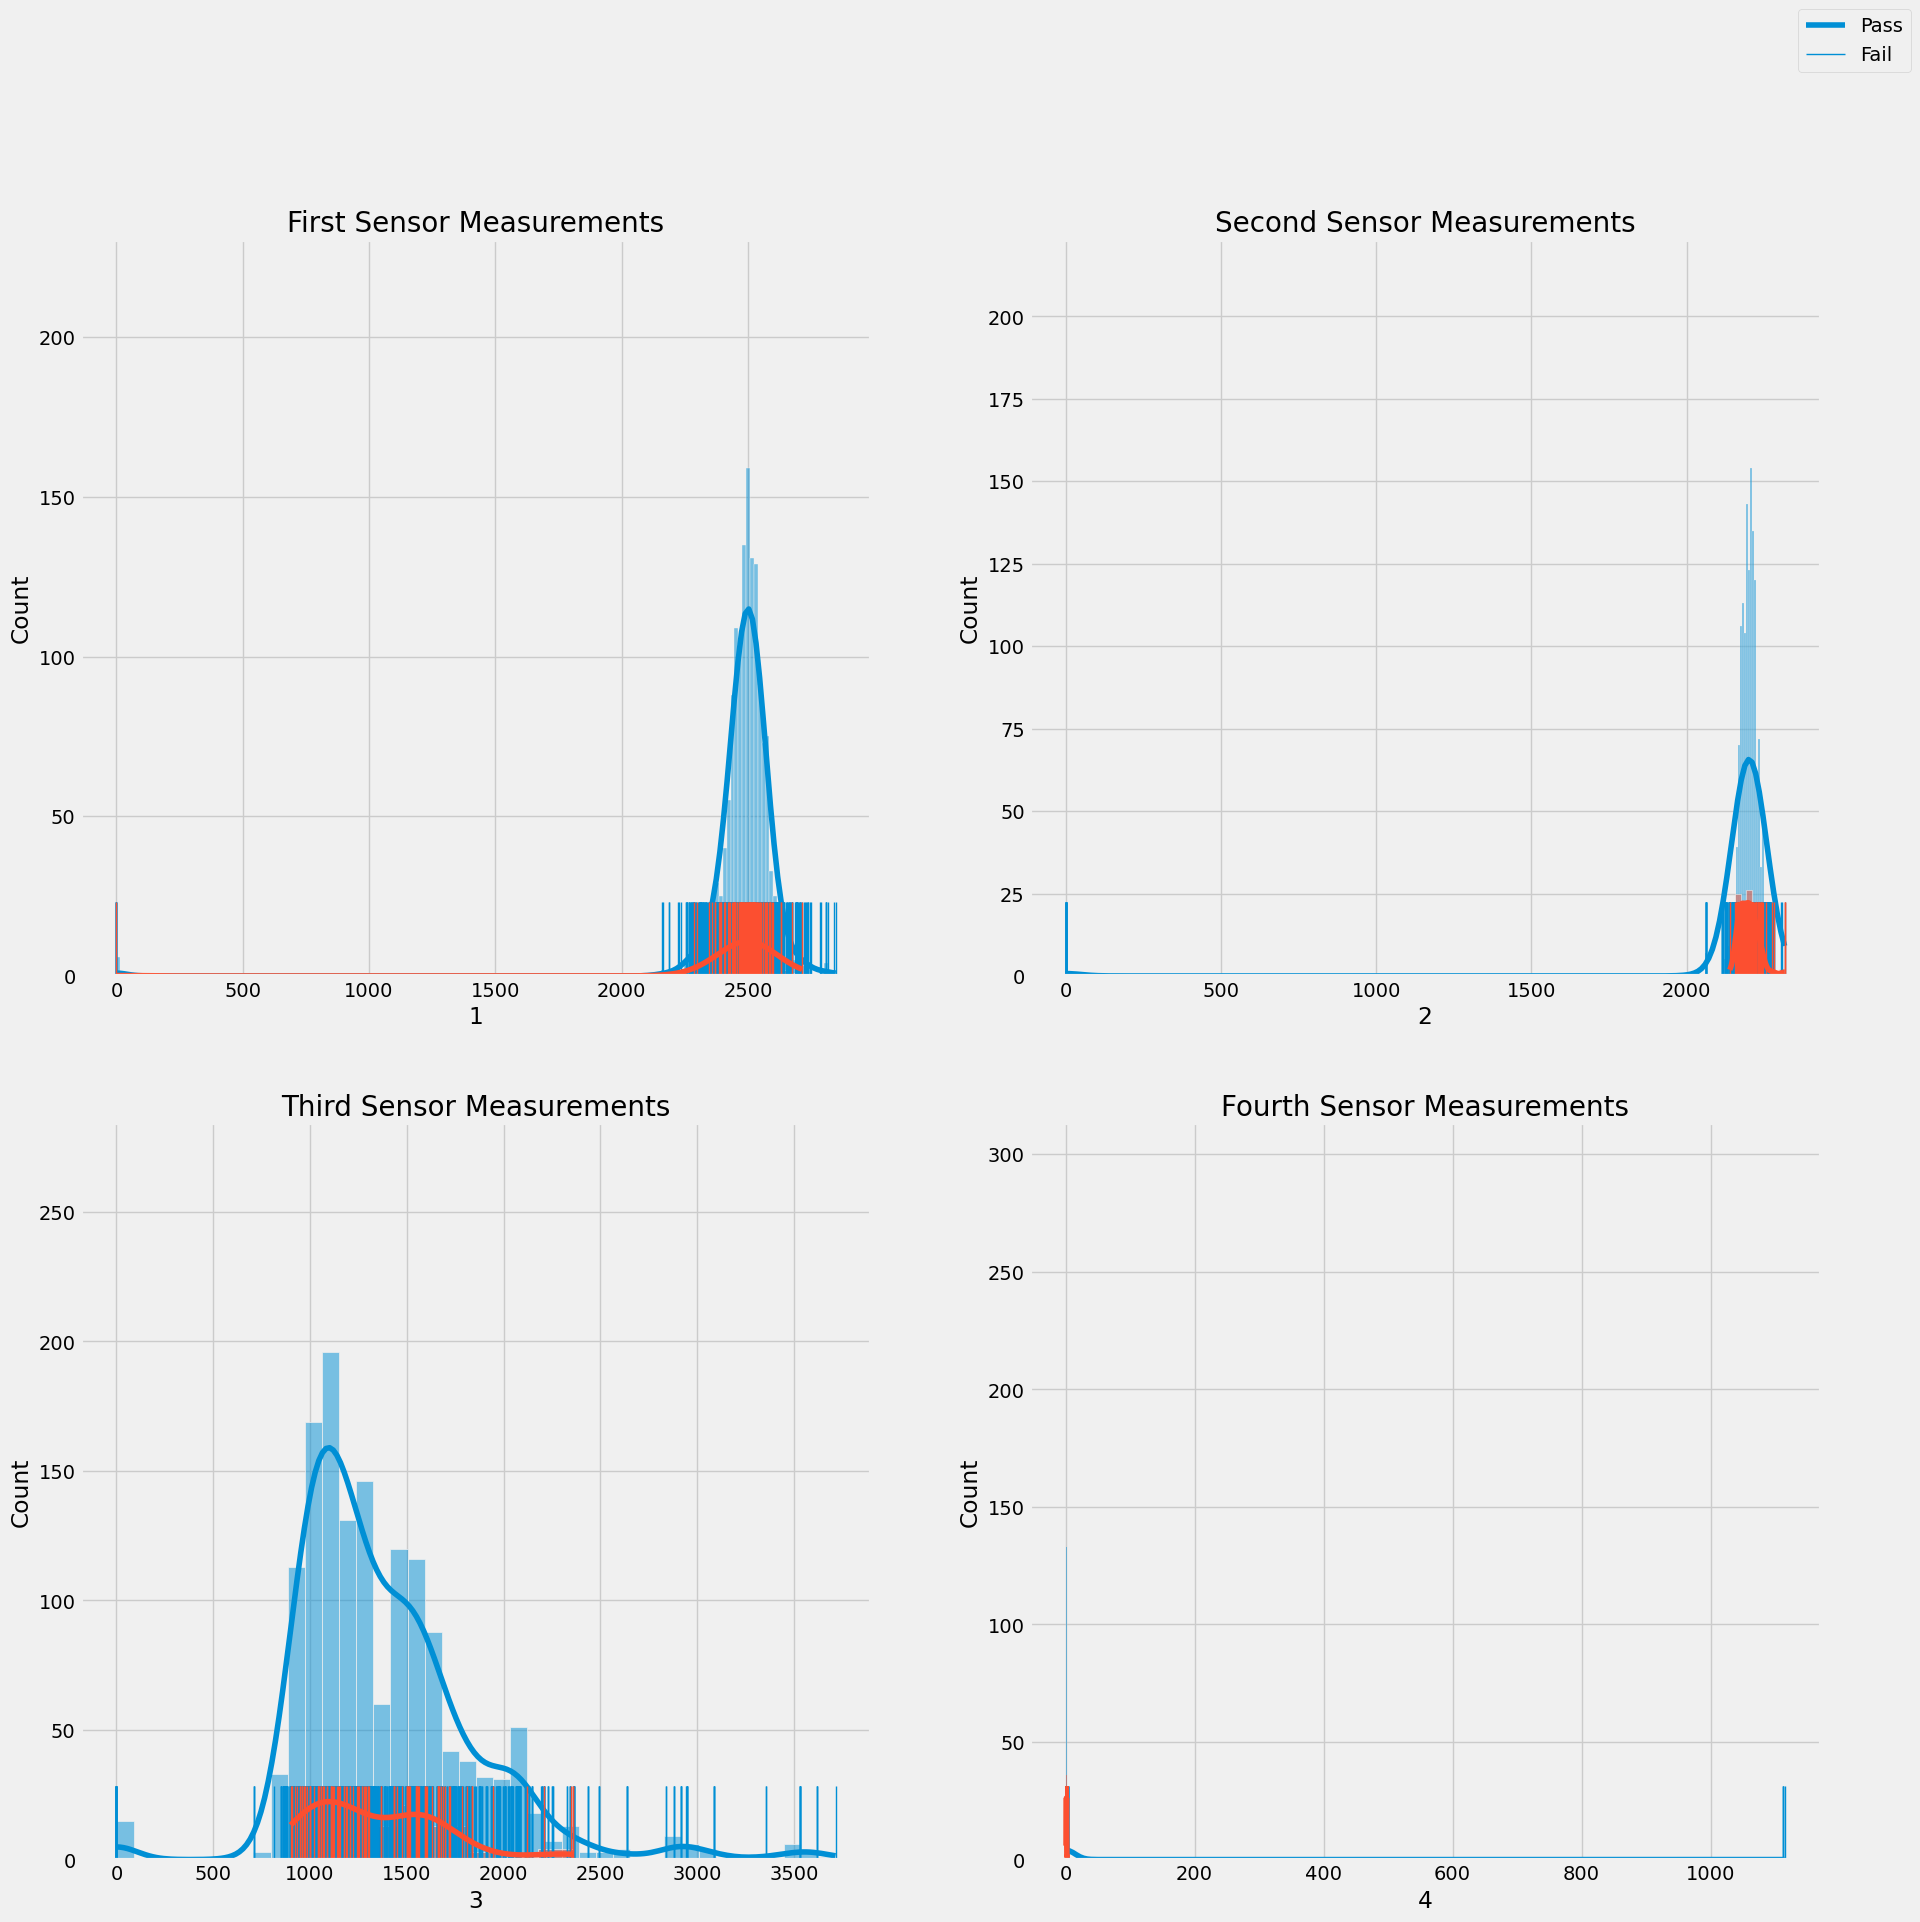

In [25]:
fig = plt.figure(figsize=(20, 20))

# 첫 번째 서브플롯
plt.subplot(2, 2, 1)
for target in targets:
    sns.histplot(target['1'], kde=True)
    sns.rugplot(target['1'], height=0.1)
plt.title('First Sensor Measurements', fontsize=20)

# 두 번째 서브플롯
plt.subplot(2, 2, 2)
for target in targets:
    sns.histplot(target['2'], kde=True)
    sns.rugplot(target['2'], height=0.1)
plt.title('Second Sensor Measurements', fontsize=20)

# 세 번째 서브플롯
plt.subplot(2, 2, 3)
for target in targets:
    sns.histplot(target['3'], kde=True)
    sns.rugplot(target['3'], height=0.1)
plt.title("Third Sensor Measurements", fontsize=20)

# 네 번째 서브플롯
plt.subplot(2, 2, 4)
for target in targets:
    sns.histplot(target['4'], kde=True)
    sns.rugplot(target['4'], height=0.1)
plt.title("Fourth Sensor Measurements", fontsize=20)

# 범례 추가
fig.legend(labels=['Pass', 'Fail'], loc='upper right')
plt.show()

#### 첫 번째 센서
 * 대부분의 값이 2500에 모여있다.
 * Pass와 Fail의 값이 뭉쳐있다.
    * 1번 센서는 유용하지 않다.
#### 두 번째 센서
 * 첫 번째 센서와 비슷한 양상이다.
    * 즉, 유용하지 않다.
#### 세 번째 센서
 * 값의 분포가 넓게 퍼져있다.
 * Pass는 500 ~ 2000에 집중
 * Fail은 1000 ~ 2500에 집중
     * 죽, 매우 유용한 세서이다.
#### 네 번째 센서
 * 값의 범위가 다른 센서들에 비해 훨씬 좁음 (대부분의 값이 0~200 사이에 위치).
 * Pass와 Fail 데이터 간의 분포 차이가 적어 보이며, Fail 값의 빈도가 특히 낮음.
     * 이 센서는 예측에 유용하지 않을 가능성이 있습니다.

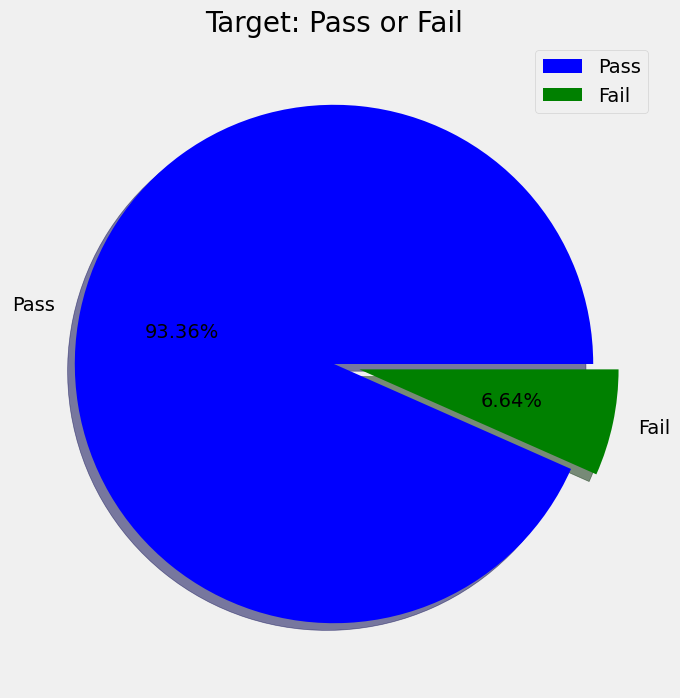

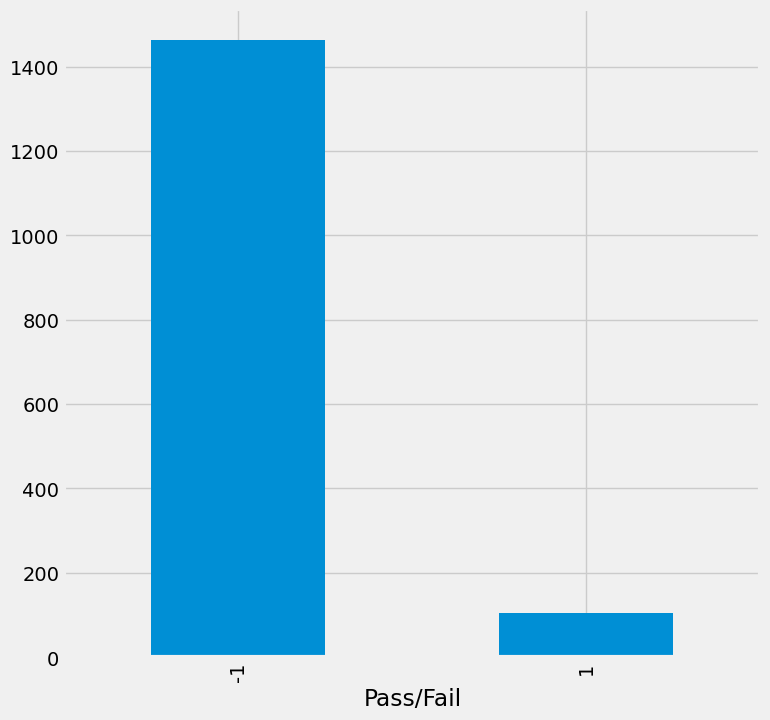

In [26]:
# 파이 차트
# 6.6%의 실패와 93.4%의 성공인 데이터셋을 가지고 있음.
# 이는 매우 불균형하며 기계 학습에 방해가 된다고 판단.

labels = ['Pass','Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue','green']
explode = [0, 0.1]

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = ( 8, 8)
plt.pie(size, labels = labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind='bar');

Text(0.5, 1.0, 'Correlation heatmap for the Data')

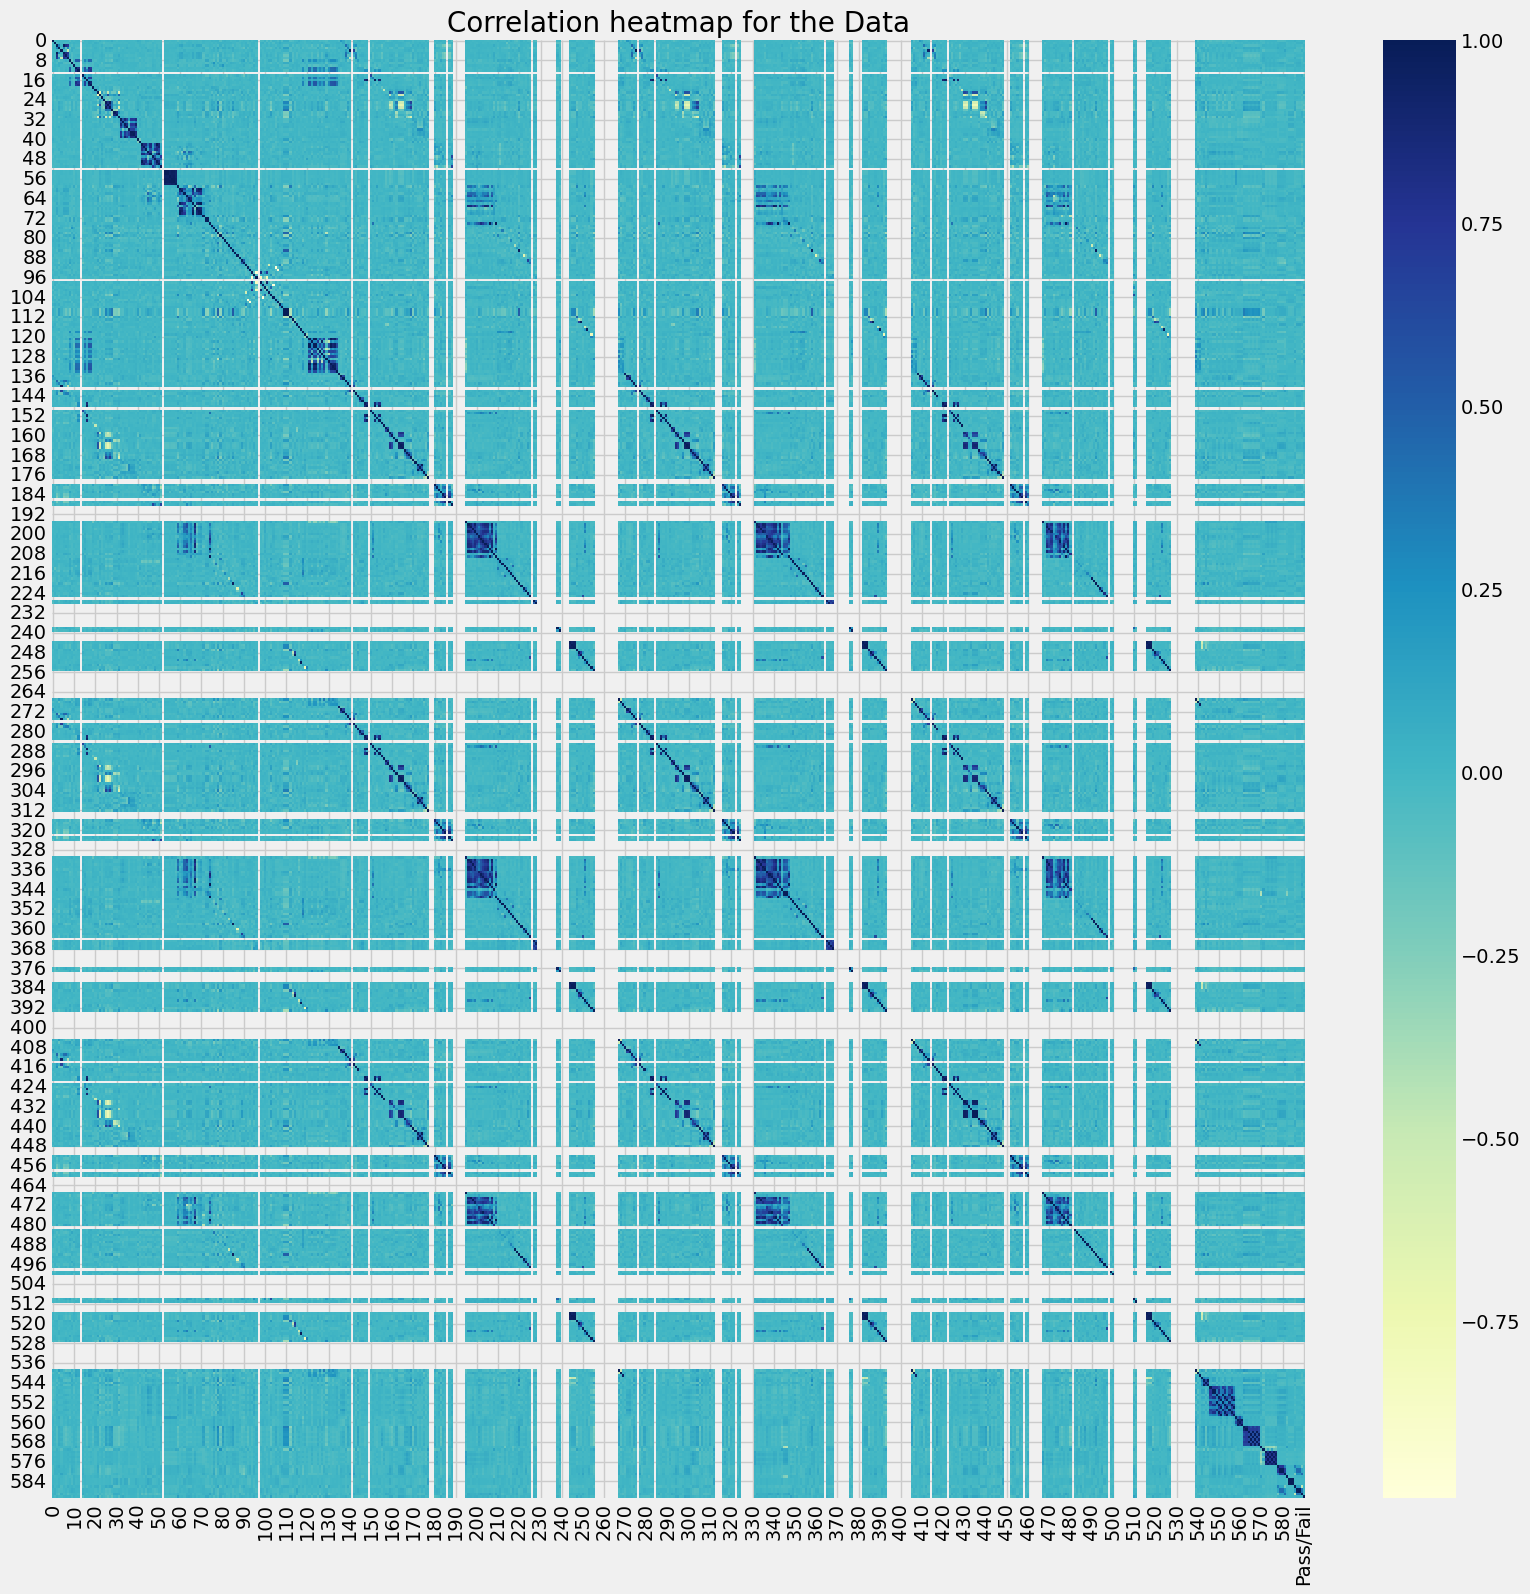

In [27]:
# heatmap to get correlation
data = data.drop(columns= ['Time'], axis = 1)

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

# Data Cleaning/Preprocessing

In [28]:
# 데이터에서 상관관계가 높은 특성들을 제거한다.

def remove_collinear_features(x, threshold):
    '''
    Objective
        데이터프레임 내에서 상관 계수가 특정 임계값(threshold) 보다 큰 열을 제거함.
        상관성이 높은 특성을 제거하면, 아래와 같은 이접이있음.
            - 모델의 일반화 능력이 향상
            - 모델의 해석 가능성(interpretability)가 개선됨.
                - 중복된 정보를 제거하면 모델이 다룰 변수가 줄어들어 더 단순해지고 명확해짐.
    Input
        1. X(features dataframe)
            특성들로 이루어진 데이터프레임. 여기서 상관성이 높은 특성을 찾아 제거함
        2. Threshhlod(임계값)
            상관 계수의 기준값
            두 특성 간 상관 계수가 이 값보다 크다면, 두 특성 중 하나를 제거한다.
    Output
        Dataframe
            높은 상관성을 가진 특성을 제거한 새로운 데이터프레임임.
            제거된 변수는 상관 계수가 임계값을 초과한 변수들임.
    '''
    # correlation matrix 계산
    corr_matrix = x.corr() # 데이터프레임 x의 상관행렬을 계산함
    iters = range(len(corr_matrix.columns) - 1) # 열의 수를 기반으로 반복 횟수를 설정함
    drop_cols = [] # 제거 대상 열을 저장하는 리스트

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)] # 상관계수를 가져옴.
            col = item.columns
            row = item.index
            val = abs(item.values) # 상관계수의 절대값을 저장함.

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # 상관관계가 있는 열 쌍 중 하나를 제거함
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x
    """
    작동 방식 요약
    1. 입력된 데이터프레임의 상관행열을 계산한다.
    2. 상관계수가 임계깞을 초과하는 열 쌍을 찾는다.
    3. 해당 열 쌍 중 하나를 제거한다.
    4. 최종적으로 상관성이 높은 열이 제거된 데이터프레임을 반환한다.
    """

In [29]:
# 70% 이상의 상관관계를 가지는 열을 제거함.
# 양수와 음수의 상관관계를 모두 고려함.
"""
왜 70% 이상인가?
    70%는 일반적으로 균형잡힌 기준으로,
    너무 민감하지도 않고 과도한 제거를 유발하지도 않는다.
    데이터 분석에서 70%는 널리 사용되는 경험적 기준이다.
"""
data = remove_collinear_features(data,0.70)

5 | 2 | 0.99
6 | 2 | 0.82
6 | 5 | 0.84
7 | 2 | 0.75
7 | 5 | 0.77
12 | 11 | 0.83
17 | 11 | 0.81
18 | 11 | 0.72
18 | 12 | 0.79
18 | 17 | 0.9
22 | 21 | 0.75
26 | 25 | 0.83
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
37 | 32 | 0.75
37 | 34 | 0.75
38 | 32 | 0.72
38 | 34 | 0.72
38 | 36 | 0.71
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 35 | 0.71
39 | 37 | 0.86
39 | 38 | 0.84
43 | 42 | 0.82
44 | 42 | 0.82
46 | 42 | 0.84
46 | 43 | 0.84
46 | 45 | 0.74
48 | 44 | 0.77
49 | 42 | 1.0
49 | 43 | 0.82
49 | 44 | 0.82
49 | 46 | 0.84
50 | 42 | 0.88
50 | 43 | 0.9
50 | 46 | 0.97
50 | 49 | 0.88
51 | 47 | 0.71
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
66 | 62 | 0.75
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
69 | 60 | 0.96
69 | 61 |

In [30]:
# 첫 번쨰 컬럼 삭제


# 데이터 확인
data.shape

(1567, 307)

In [31]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [32]:
# 독립 변수와 종속 변수의 값을 데이서에서 분리한다.
x = data.iloc[:,:306]
# 데이터 프레임의 앞부분 306개의 열을 추출한 부분
# 기계 학습 모델에서 예측에 필요한 입력 데이터로 사용된다.

y = data["Pass/Fail"]
# 데이터 프레임의 [Pass/Fail]을 선택함.
# 모델이 예측하려는 타겟 값이다.

# 데이터 형태의 확인
print('shape of x : ', x.shape)
print("shape of y : ", y.shape)
print("")
print("There is  NaN in x :",x.isnull().any().any())
print("There is  NaN in y :",y.isnull().any().any())

#  데이터의 형태를 확인한 이유
#      기계 학습 모델을 훈련시키기 위해서는 입력 데이터(x)와 출력 데이터(y)의 크기가 일치해야함.
#      그러므로 데이터의 형태를 확인함.
        


shape of x :  (1567, 306)
shape of y :  (1567,)

There is  NaN in x : False
There is  NaN in y : False


In [33]:
# 훈련 데이터와 테스트 데이터를 나누기

from sklearn.model_selection import train_test_split # 데이터를 훈련, 테스트 데이터로 나누기 위한 함수

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)
"""
    파라미터 설명
        x / y
            x : 입력 특성(독립 변수)
            y : 타겟 값(종속 변수)
        test_size
            데이터를 훈련/테스트로 7:3으로 나눔
        random_state=1
            데이터를 나누는 방식을 고정함
"""
# getting the shape of the Data
print("shape of x_train :", x_train.shape)  # 70%의 데이터가 훈련용으로 사용됨
print("shape of x_test :", x_test.shape)    # 30%의 데이터가 테스트용으로 사용됨
print("shape of y_train :",y_train.shape)   # 타겟 값도 70%가 훈련용
print("shape of y_test :",y_test.shape)     # 타겟 값도 30%가 테스트용

shape of x_train : (1096, 306)
shape of x_test : (471, 306)
shape of y_train : (1096,)
shape of y_test : (471,)


In [34]:
# 표준화
"""
    표준화의 목적 : 모델의 성능을 향상시키고 안정석을 확보하기 위해 데이터의 스케일을 조정함
    1. 특성간 스케일 정규화
    2. 경사 하강법 기반 모델의 안정적  학습
    3. 거리 기반 알고리즘의 성능 향상
"""
from sklearn.preprocessing import StandardScaler # 데이터 표준화 도구로 평균을 0, 분산을 1로 변환한다.

# standard scaler 제작
sc = StandardScaler() # <- 표준화를 수행할 객체를 생성한다.

# 모델에 독립 변수 넣기
x_train = sc.fit_transform(x_train)
"""
    fit_transform : 데이터를 학습(fit) 하고 변환(transform)한다.
        학습(fit) : 데이터의 평균과 표준편차를 계산한다.
        변환(transform) : 계산된 평균과 표준편차를 사용하여 데이터를 변환한다.
    결과적으로 x_train의 평균은 0, 표준편차는 1로 변환된다.
"""

x_test = sc.transform(x_test)
# 훈련 데이터에서 계산된 평균과 표준편차를 사용하여 테스트 데이터를 변환한다.


# XGBoost Algorithm (Normal data)

In [35]:
"""
원래 이 데이터 셋에서는 -1 이 Pass 를 1이 fail을 의미했다.
XGBCLassifier가 종속 변수 y에 있는 클래스 레이블에 [0, 1] 이 아니라 [-1, 1]
이 있기 때문에 오류가 발생한다.
따라서 앞으로는 0이 Fail을  1이 Pass를 의미한다.
"""


y_train = y_train.replace(-1,0) # Pass -> 0
y_test = y_test.replace(-1, 0)   # Pass -> 0

# 난수 생성기의 초기값을 1로 설정하여 동일한 결과를 재현할 수 있게 한다.
model = XGBClassifier(random_state=1) 
# x_train의 특징 데이터를 기반으로 y_train의 정답 레이블을 학습한다.
model.fit(x_train, y_train)
# x_test 는 데스트 데이터로, 학습에 사용되지 않은 독립 변수이다.
y_pred = model.predict(x_test)
print("클래스 레이블 확인 (y_train):",y_train.unique())
print("클래스 레이블 확인 (y_test):",y_test.unique())

클래스 레이블 확인 (y_train): [0 1]
클래스 레이블 확인 (y_test): [0 1]


<Axes: >

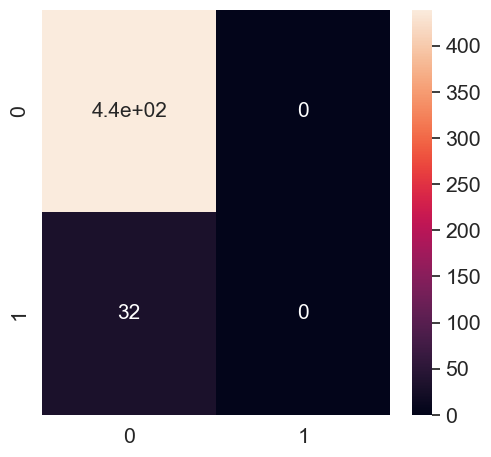

In [36]:
# 혼동 행렬을 계산
# y_test : 실제 레이블
# y_pred : 모델이 예측한 레이블
# 행은 실제 클래스, 열은 예측한 클래스를 나타냄

cm = confusion_matrix(y_test, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [37]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (471, 306)
y_test shape: (471,)


In [44]:
print("Accuracy : ", model.score(x_test,y_test)*100)


Accuracy :  93.20594479830149


### XGBoost 알고리즘 분석 결과 
1. True Negative(TN) : 440
   * 실제로 Pass(0)인 데이터가 모델에서 Pass(0)로 올바르게 예측된 경우
   * 모델이 정확하게 맞춘 Pass(0) 데이터임
2. False Positive (FP) : 1
   * 실제로 Pass(0)인데 모델이 잘못 예측하여 Fail(1)로 분류한 경우
   * 잘못된 예측이 발생했음
3. False Negative (FN) : 32
   * 실제로 Fail(1)인데 모델이 잘못 에측하여 Pass(0)로 분류한 경우
   * Fail(1)을 제대로 감지하지 못한 경우
4. True Positive (TP) : 0
   * 실제로 Fail(1)인 데이터를 모델이 Fail(1)로 정확히 예측한 경우
   * Fail(1)을 하나도 감지하지 못함

### 결론
장점 :
    * Pass(0)를 잘 예측하는 데 매우 높은 정확도를 보여준다.
단점 :
    * Fail(1)을 완전히 예측하지 못함 (TP의 부재)

### 문제점과 개선 방향
1. 문제점
   * 데이터의 불균형으로 모델이 Fail(1)을 거의 예측하지 못하고 Pass(0)으로 치우친 결과를 보임
2. 개선방향
   * 데이터 증강을 통해 불균형 문제 해결

# Random Foresst Classifier (Normal Data)

In [45]:
# 100개의 트리를 생성, 학습 과정에서 로그 출력은 F
model = RandomForestClassifier(n_estimators=100, random_state=1, verbose=0 )
# 모델을 x_train과 Y_train 으로 학습시킨다.
model.fit(x_train, y_train)
# y_pred에 예측 결과를 대입한다.
y_pred = model.predict(x_test)

<Axes: >

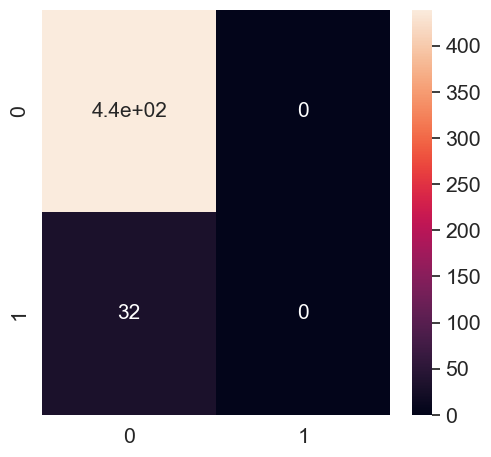

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap (cm, annot = True, annot_kws = {"size" : 15})

In [47]:
print("Accuracy : ", model.score(x_test,y_test) * 100)

Accuracy :  93.20594479830149


### RandomForest 알고리즘 분석 결과 
1. True Negative(TN) : 440
   * 실제로 Pass(0)인 데이터가 모델에서 Pass(0)로 올바르게 예측된 경우
   * 모델이 정확하게 맞춘 Pass(0) 데이터임
2. False Positive (FP) : 0
   * 실제로 Pass(0)인데 모델이 잘못 예측하여 Fail(1)로 분류한 경우
   * 잘못된 예측이 발생했음
3. False Negative (FN) : 32
   * 실제로 Fail(1)인데 모델이 잘못 에측하여 Pass(0)로 분류한 경우
   * Fail(1)을 제대로 감지하지 못한 경우
4. True Positive (TP) : 0
   * 실제로 Fail(1)인 데이터를 모델이 Fail(1)로 정확히 예측한 경우
   * Fail(1)을 하나도 감지하지 못함

### 결론
장점 :
    * Pass(0)를 잘 예측하는 데 매우 높은 정확도를 보여준다.
단점 :
    * Fail(1)을 완전히 예측하지 못함 (TP의 부재)

### 문제점과 개선 방향
1. 문제점
   * 데이터의 불균형으로 모델이 Fail(1)을 거의 예측하지 못하고 Pass(0)으로 치우친 결과를 보임
2. 개선방향
   * 데이터 증강을 통해 불균형 문제 해결

# Logistic Regression (Normal Data)

In [48]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

<Axes: >

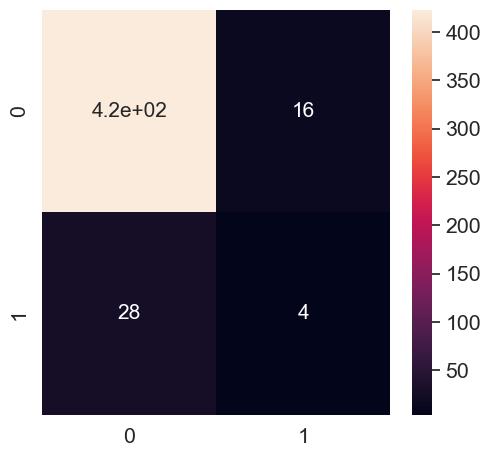

In [49]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {'size' : 15})

In [50]:
print("Accuracy : ",lr.score(x_test,y_test)*100)

Accuracy :  90.65817409766454


### Logistic Regression 알고리즘 분석 결과 
1. True Negative(TN) : 440
   * 실제로 Pass(0)인 데이터가 모델에서 Pass(0)로 올바르게 예측된 경우
   * 모델이 정확하게 맞춘 Pass(0) 데이터임
2. False Positive (FP) : 16
   * 실제로 Pass(0)인데 모델이 잘못 예측하여 Fail(1)로 분류한 경우
   * 잘못된 예측이 발생했음
3. False Negative (FN) : 28
   * 실제로 Fail(1)인데 모델이 잘못 에측하여 Pass(0)로 분류한 경우
   * Fail(1)을 제대로 감지하지 못한 경우
4. True Positive (TP) : 4
   * 실제로 Fail(1)인 데이터를 모델이 Fail(1)로 정확히 예측한 경우
   * Fail(1)을 하나도 감지하지 못함

### 결론
장점 :
    * Pass(0)를 잘 예측하는 데 매우 높은 정확도를 보여준다.
단점 :
    * Fail(1)을 완전히 예측하지 못함 (TP의 부재)

### 문제점과 개선 방향
1. 문제점
   * 데이터의 불균형으로 모델이 Fail(1)을 거의 예측하지 못하고 Pass(0)으로 치우친 결과를 보임
2. 개선방향
   * 데이터 증강을 통해 불균형 문제 해결

# Lasso (Normal Data)

In [51]:
# alpha : 값이 적을수록 회귀 모형에 가깝다. 
lasso = Lasso(alpha=0.1, random_state=1)
lasso.fit(x_train, y_train)


y_pred = lasso.predict(x_test)

y_pred2 = np.sign(y_pred)

In [52]:
print("Accuracy : ", lasso.score(x_test,y_test)*100)

Accuracy :  -0.007974076019090504


<Axes: >

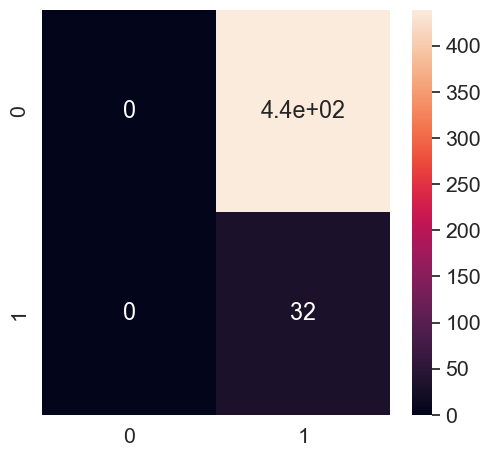

In [53]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True)

### RandomForest 알고리즘 분석 결과 
1. True Negative(TN) : 0
   * 실제로 Pass(0)인 데이터가 모델에서 Pass(0)로 올바르게 예측된 경우
   * 모델이 정확하게 맞춘 Pass(0) 데이터임
2. False Positive (FP) : 440
   * 실제로 Pass(0)인데 모델이 잘못 예측하여 Fail(1)로 분류한 경우
   * 잘못된 예측이 발생했음
3. False Negative (FN) : 0
   * 실제로 Fail(1)인데 모델이 잘못 에측하여 Pass(0)로 분류한 경우
   * Fail(1)을 제대로 감지하지 못한 경우
4. True Positive (TP) : 32
   * 실제로 Fail(1)인 데이터를 모델이 Fail(1)로 정확히 예측한 경우
   * Fail(1)을 하나도 감지하지 못함

### 결론
단점 :
    * Fail(1)을 예측하더라고 정확도가 매우 낮음

### 문제점과 개선 방향
1. 문제점
   * Pass(0)와 Fail(1)을 거의 예측하지못함 데이터의 불균형이 원인.
2. 개선방향
   * 데이터 증강을 통해 불균형 문제 해결

# UnderSampling of the Dataset

In [54]:
failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)
# no = Number of
print(no_failed_tests)
# 데이터셋에 실패가 얼마나 있는지 출력

104


In [55]:
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)
# no = Number of
print(no_normal_indices)
# 데이터셋에 성공이 얼마나 있는지 출력

1463


In [56]:
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
# no_normal_indices(성공) 배열에서 no_failed_tests(실패)) 개수만큼 랜덤하게 값을 선택한다.
# replace = True 옵션은 값이 여러 번 선택될 수 있도록 허용한다.

random_normal_indices = np.array(random_normal_indices)
# random_normal_indices를 배열로 변환

print("Random normal indices :\n", random_normal_indices)
print("Length of the random normal indices :",len(random_normal_indices)) 

Random normal indices :
 [ 904 1127  243  623 1202  767   11   25  253  704  563  810  543 1135
   56   66  384   76  903  253  326  808 1404 1099 1351 1008  440   61
  800  386  261   62  126  603    4  514  643  995  304 1063 1089  508
    4 1023   96 1067  994   80 1384  547  394  966  365  872  415 1178
   56 1035  541  433   73  953  455 1458  165  308  373  257 1089 1221
  673  111 1338  618 1024   13  120  171  499 1244 1172  276  404 1026
 1135  849  434 1457   98  591 1255  331   90  152  836 1408 1185  956
  122  832 1396 1276  569 1319]
Length of the random normal indices : 104


In [57]:
# failed_testd와 random_normal_indices를 합친다.
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [58]:
# creating the undersample data
undersample_data = data.iloc[under_sample, :]

In [59]:
# Undersampling 한 데이터를 X에는 입력 변수를 Y에는 타겟변수를 대입한다.
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print("x shape :",x.shape)
print("y shape :",y.shape)

x shape : (208, 306)
y shape : (208, 1)


In [60]:
# 입력 변수와 타겟 변수의 훈련 데이터와 테스트 데이터의 비율을 7:3비율로 나눈다.
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [61]:
# 데이터 표준화를 하여 평균을 0 분산을 1로 맞춘다.


sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

# [-1, 1] 을 [0, 1]로 바꿈
y_train_us = y_train_us.replace(-1,0)
y_test_us = y_test_us.replace(-1,0)

print("Train target distribution:")
print(y_train_us.value_counts())

print("Test target distribution:")
print(y_test_us.value_counts())

Train target distribution:
Pass/Fail
1            77
0            68
Name: count, dtype: int64
Test target distribution:
Pass/Fail
1            35
0            28
Name: count, dtype: int64


# Xg-Boost Classifier (Undersampling)


In [62]:
model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

# Confusion Matrix after UnderSampling with XgBoost

<Axes: >

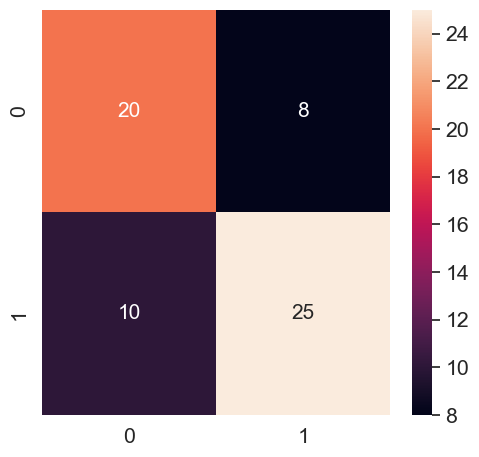

In [63]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})


In [64]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  56.90021231422505


### XgBoost(Undersampling) 알고리즘 분석 결과 
1. True Negative(TN) : 19
   * 실제로 Pass(0)인 데이터가 모델에서 Pass(0)로 올바르게 예측된 경우
   * 모델이 정확하게 맞춘 Pass(0) 데이터임
2. False Positive (FP) : 8
   * 실제로 Pass(0)인데 모델이 잘못 예측하여 Fail(1)로 분류한 경우
   * 잘못된 예측이 발생했음
3. False Negative (FN) : 13
   * 실제로 Fail(1)인데 모델이 잘못 에측하여 Pass(0)로 분류한 경우
   * Fail(1)을 제대로 감지하지 못한 경우
4. True Positive (TP) : 23
   * 실제로 Fail(1)인 데이터를 모델이 Fail(1)로 정확히 예측한 경우
   * Fail(1)을 하나도 감지하지 못함

# Grid Search - XG Boost (Undersampling)

In [65]:
# Grid Search란?

"""
    머신러닝 모델의 하이퍼파라미터의 최적화를 위해 가장 널리 사용되는 기법 중 하나
    하이퍼파라미터 : 머신러닝 모델의 학습 과정에서 조정해야 하는값으로 사전에 설정해야함
"""
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [66]:
print("Best Accuracy : ", best_accuracy*100)
print("Best Parameter : ", best_parameters)

Best Accuracy :  64.13793103448275
Best Parameter :  {'max_depth': 4, 'random_state': 1}


# Over-Sampling with SMOTE

In [67]:
'''
    SMOTE란
    불균형 데이터셋에서 소수 클래스의 데이터를 오버 샘플링하여
    균형을 맞추는 기법
'''


# SMOTE 초기화
smote = SMOTE(random_state=1)

# 데이터를 오버샘플링하여 균형 맞춤
x_resample, y_resample = smote.fit_resample(x, y.values.ravel())

print(x_resample)
print(y_resample)

               0            1            2            3         4         8  \
0    2932.610000  2559.940000  2186.411100  1698.017200  1.510200  1.443600   
1    2994.050000  2548.210000  2195.122200  1046.146800  1.320400  1.514400   
2    2928.840000  2479.400000  2196.211100  1605.757800  0.995900  1.469000   
3    2963.970000  2629.480000  2224.622200   947.773900  1.292400  1.447400   
4    2884.740000  2514.540000  2160.366700   899.948800  1.402200  1.558500   
..           ...          ...          ...          ...       ...       ...   
219  3181.458929  2483.346672  2252.878652  1974.791543  1.301064  1.516635   
220  3037.687587  2468.604260  2209.605998  1188.856521  1.772158  1.545041   
221  2950.317353  2495.449861  2221.618610  1209.625235  1.212666  1.618108   
222  2979.585722  2448.268267  2198.915734  1307.238643  1.419510  1.450330   
223  2888.707156  2558.664963  2211.168482  1334.340205  1.076683  1.417105   

            9        10        11   13  ...       5

In [68]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape) 
print(y_train_os.shape) 
print(x_test_os.shape) 
print(y_test_os.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [69]:
# 표준화

sc = StandardScaler()

x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.fit_transform(x_test_os)

y_train_os = y_train_os.replace(-1, 0)
y_test_os = y_test_os.replace(-1, 0)

print("x_train_os shape:", x_train_os.shape)
print("x_test_os shape:", x_test_os.shape)
print("y_train_os distribution:", np.unique(y_train_os, return_counts=True))
print("y_test_os distribution:", np.unique(y_test_os, return_counts=True))

x_train_os shape: (145, 306)
x_test_os shape: (63, 306)
y_train_os distribution: (array([0, 1]), array([68, 77]))
y_test_os distribution: (array([0, 1]), array([28, 35]))


# Lasso Oversampling

In [96]:
lasso = Lasso(alpha=0.1, random_state=1)
lasso.fit(x_train_os, y_train_os)


y_pred = lasso.predict(x_test_os)

y_pred2 = np.sign(y_pred)

# Confusion Matrix after Oversampling with Lasso

<Axes: >

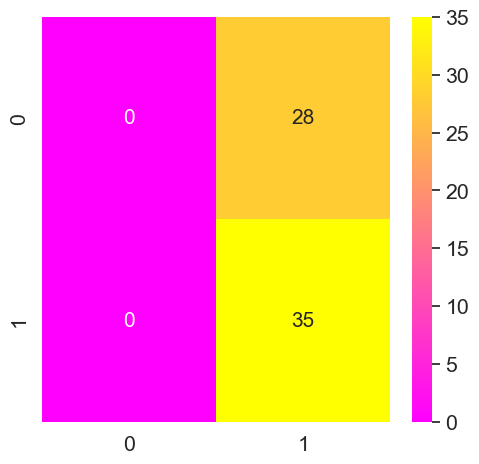

In [97]:
cm = confusion_matrix(y_test_os, y_pred2)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style= 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'spring')

# Xg-Boost Classifier(

In [72]:
model = XGBClassifier(random_state = 1)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

# Confusion Matrix after OverSampling with XGBoost

<Axes: >

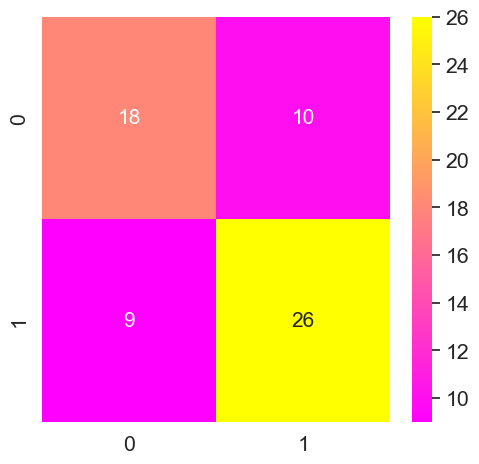

In [73]:
cm = confusion_matrix(y_test_os, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [74]:
print("Accuracy :", model.score(x_test, y_test)*100)

Accuracy : 56.90021231422505


# Random Forest (Oversampling)

In [75]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 ) 
model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

Accuracy:  74.60317460317461


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Random Forest - (Oversampled) - COnfusion Matrix

<Axes: >

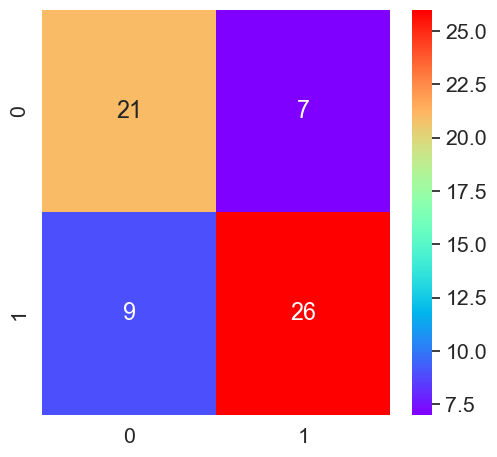

In [76]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap= 'rainbow')

# Logisric regression - (Oversampled)

In [77]:
lr = LogisticRegression(random_state = 1)
lr.fit(x_train_os, y_train_os)
y_pred = lr.predict(x_test_os)

print("Accuracy :", lr.score(x_test_os,y_test_os)*100)

Accuracy : 84.12698412698413


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Logistic regression - (Oversmapled) - Confusion Matrix

<Axes: >

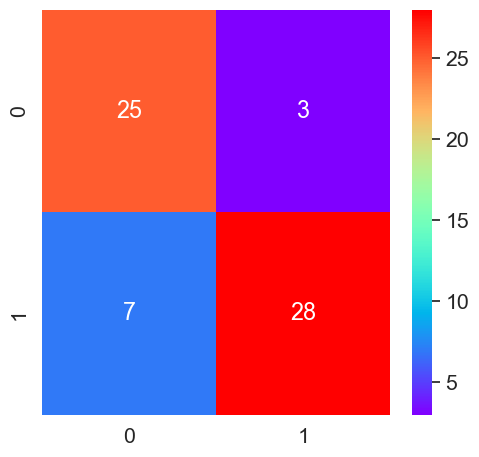

In [78]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap ="rainbow")

# Rnadom Forest - (Undersampled)

In [79]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Confusion Matrix for Random Forest (Undersampled)

<Axes: >

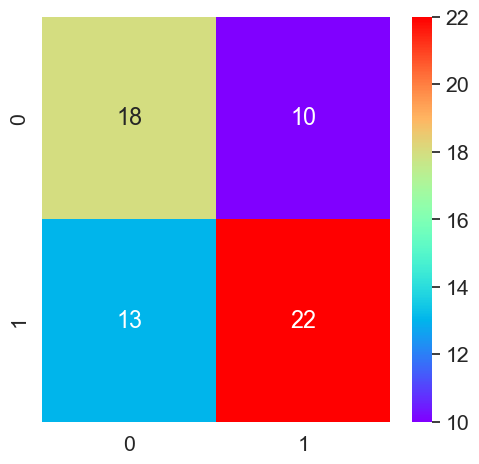

In [80]:
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap='rainbow')

In [81]:
print("Accuracy :", model.score(x_test,y_test)*100)

Accuracy : 50.74309978768577


# Using Lasso (Undersampled)

In [82]:
lasso = Lasso(alpha=0.1, random_state= 1)
lasso.fit(x_train_us,y_train_us)

Lasso(alpha=0.1, random_state=1)

In [83]:
y_pred = lasso.predict(x_test_us)

In [84]:
print(y_pred)

[0.58359735 0.4947969  0.52218797 0.53165546 0.56860724 0.53998031
 0.51430948 0.52676088 0.53197254 0.56960682 0.58572035 0.56748273
 0.60054403 0.43812523 0.52660372 0.46266808 0.44943943 0.53392502
 0.57415046 0.52049179 0.49601911 0.58991847 0.63034796 0.55597879
 0.60879141 0.46614723 0.58783797 0.53162717 0.55123341 0.63515294
 0.55049045 0.57623288 0.53684295 0.51056898 0.54542592 0.51346264
 0.60498511 0.50728847 0.48242958 0.54804559 0.5278184  0.47744675
 0.46872625 0.51231533 0.53611859 0.54408702 0.47353851 0.51037615
 0.59154009 0.50566957 0.45980109 0.48199164 0.55584803 0.5237589
 0.60749038 0.51632523 0.54239268 0.53815115 0.51729438 0.51451451
 0.51262799 0.52301404 0.58540511]


In [85]:
y_test_us

,Pass/Fail
404,0
966,0
953,0
1185,1
495,1
...,...
1302,1
273,1
563,0
800,0


In [86]:
y_pred2 = np.sign(y_pred)

# Confusion matrix for Lasso (Undersampled)

<Axes: >

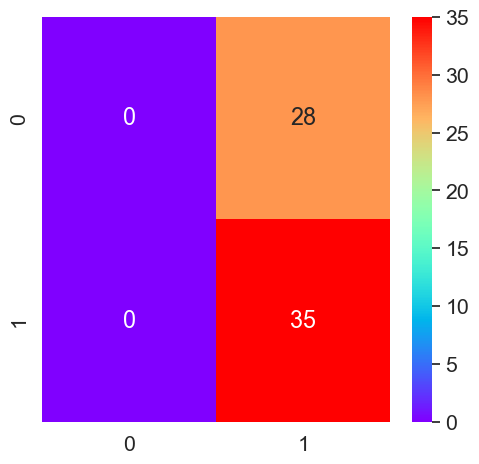

In [87]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap='rainbow')

In [88]:
print("Accuracy :", lasso.score(x_test_us, y_test_us)*100)

Accuracy : 2.895417395678701


# Logistic Regression (Undersampled)

In [89]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=1)

In [90]:
y_pred=lr.predict(x_test_us)

# Confusion matrix for Logistic Regression (Undersampled)

<Axes: >

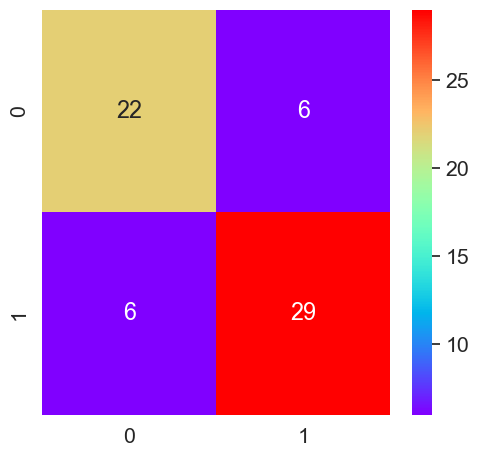

In [91]:
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap='rainbow')

In [92]:
print("Accuracy :",lr.score(x_test,y_test)*100)

Accuracy : 59.23566878980891


# COmparison of ALl Algorithms' Recall Rate

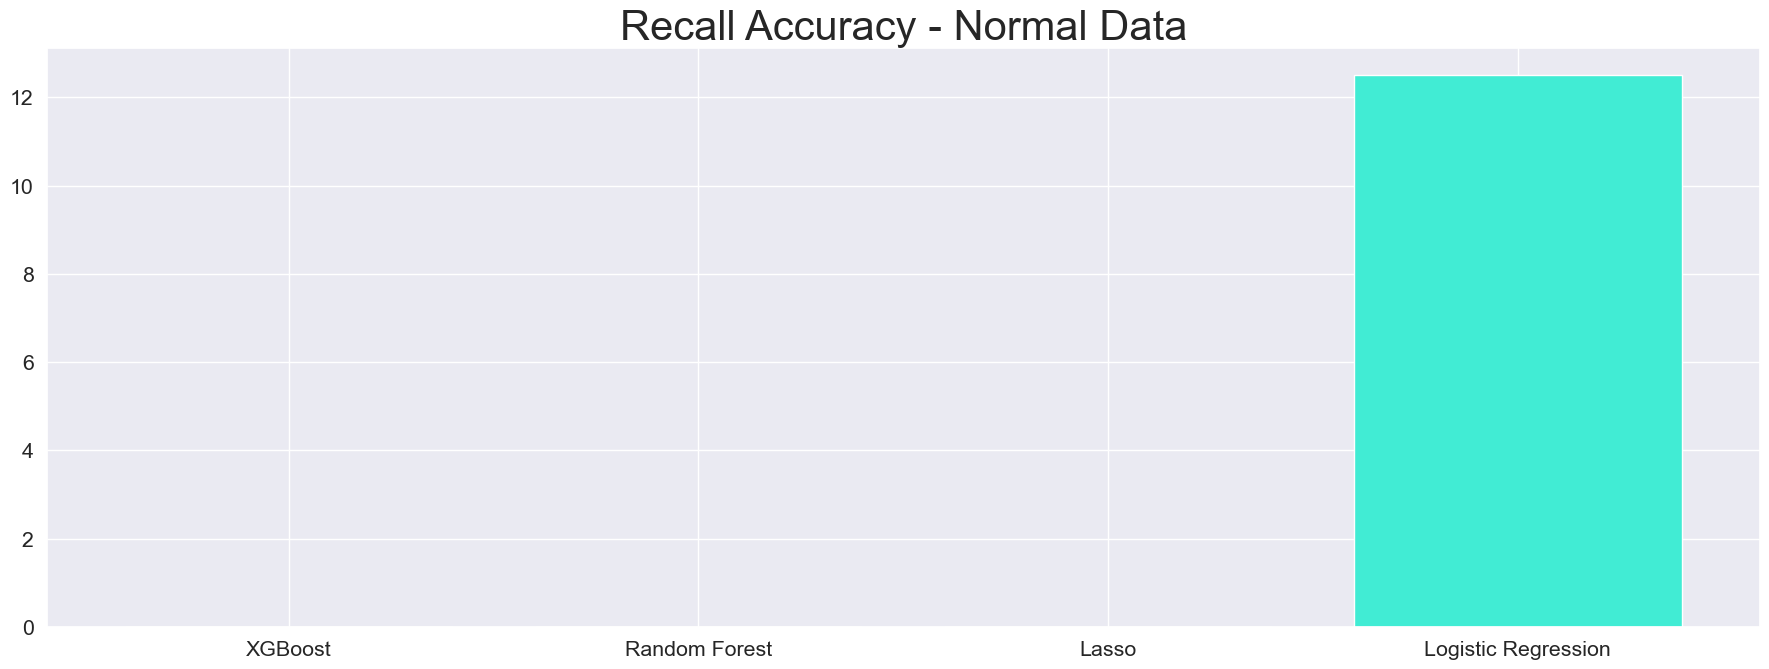

In [93]:
Recall = np.array([0,0,12.5,0])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7) 
plt.bar(range(len(indices)), Recall[indices], color = color) 
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Normal Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

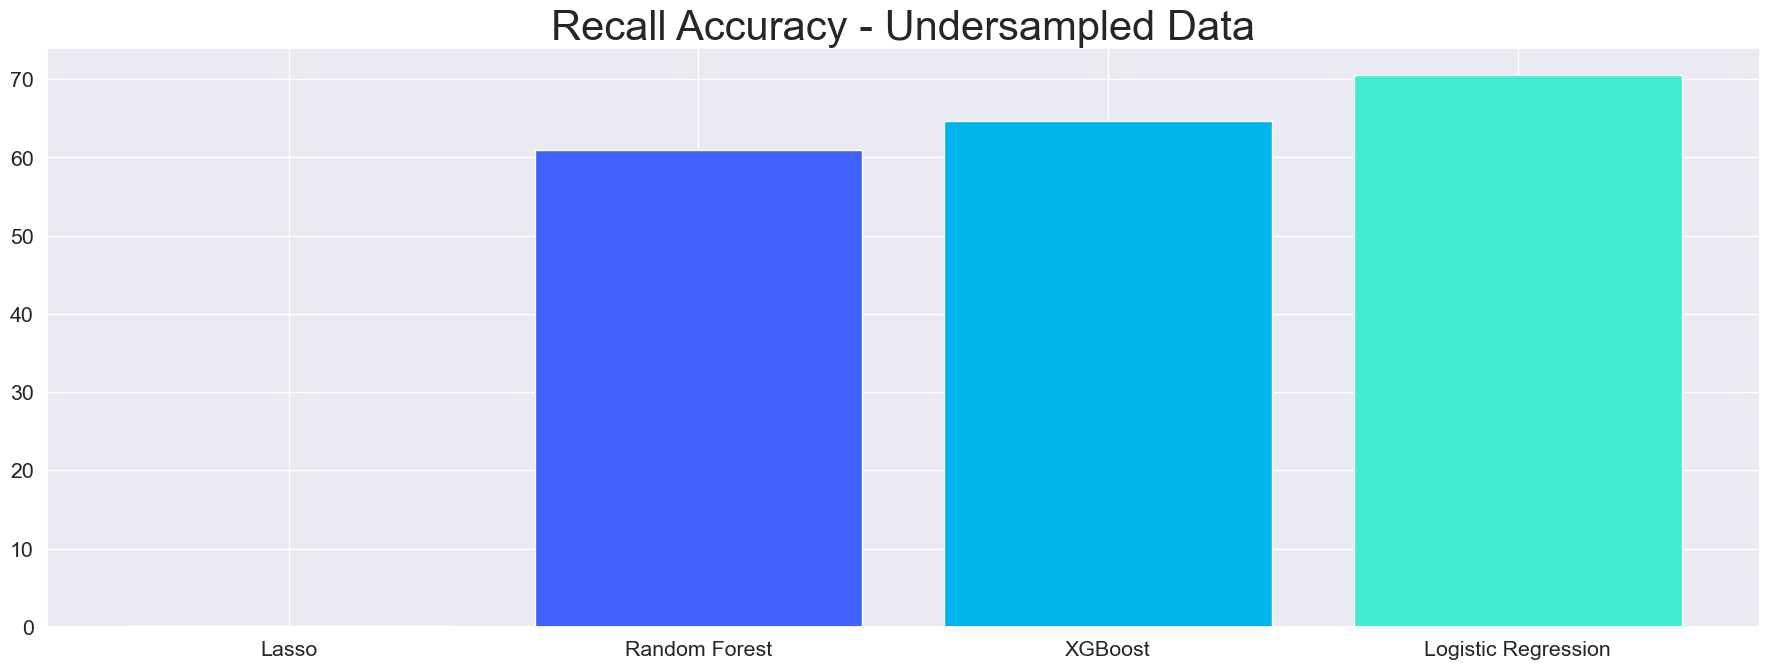

In [94]:
Recall = np.array([64.7,61, 70.5, 0.1])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("Recall Accuracy - Undersampled Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

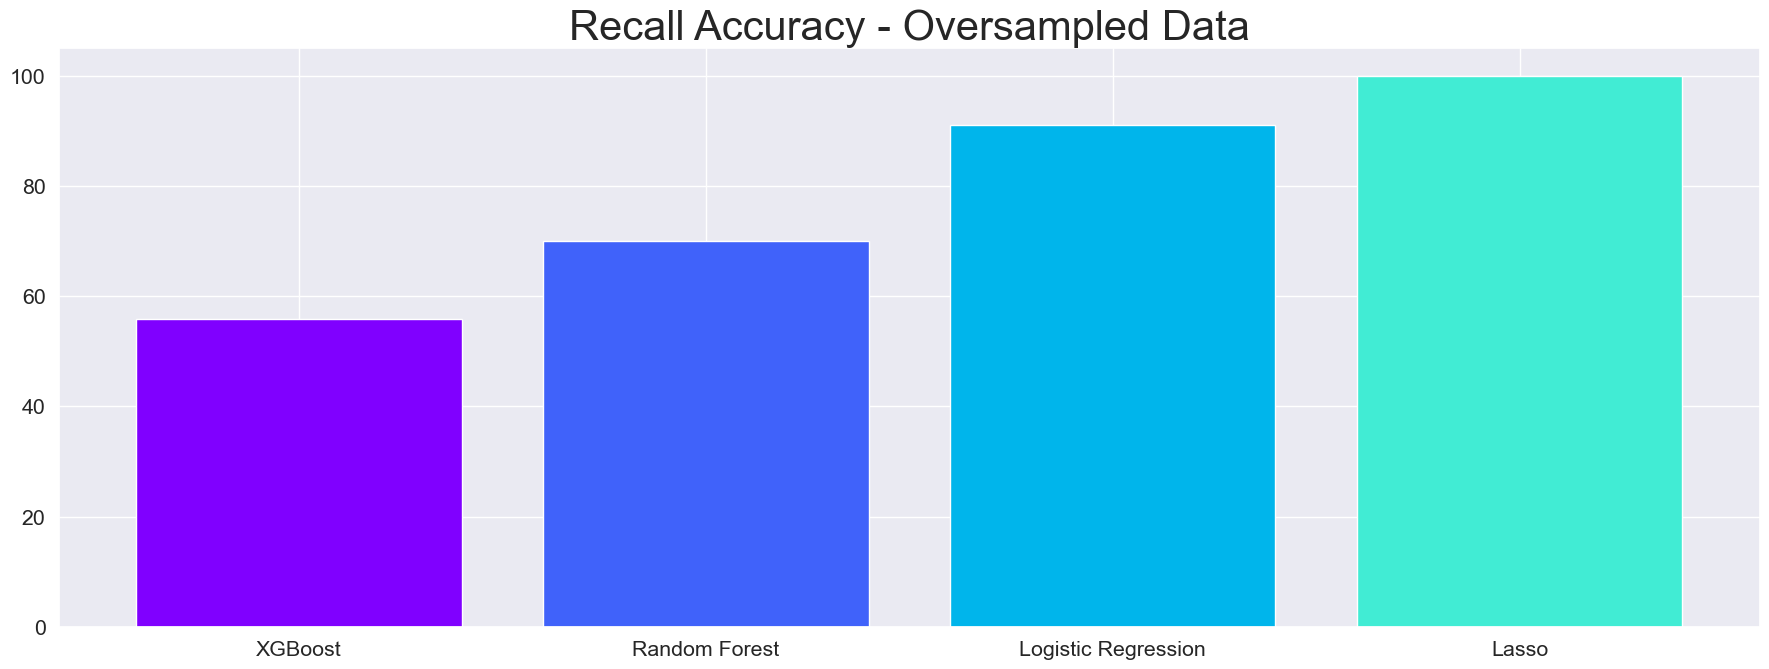

In [98]:
Recall = np.array([55.8,70,91,100])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("Recall Accuracy - Oversampled Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

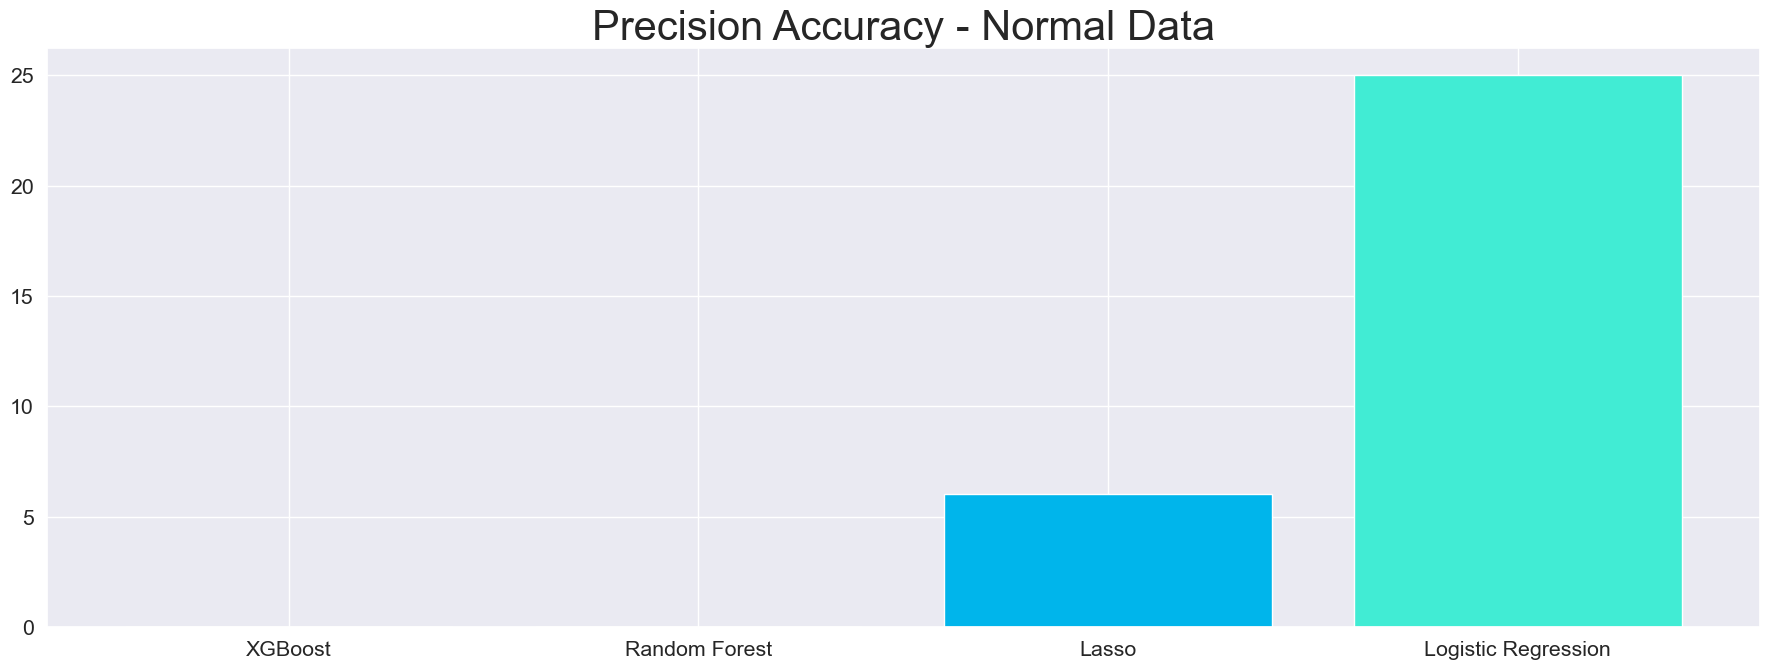

In [103]:
Recall = np.array([0,0,25,6])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("Precision Accuracy - Normal Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

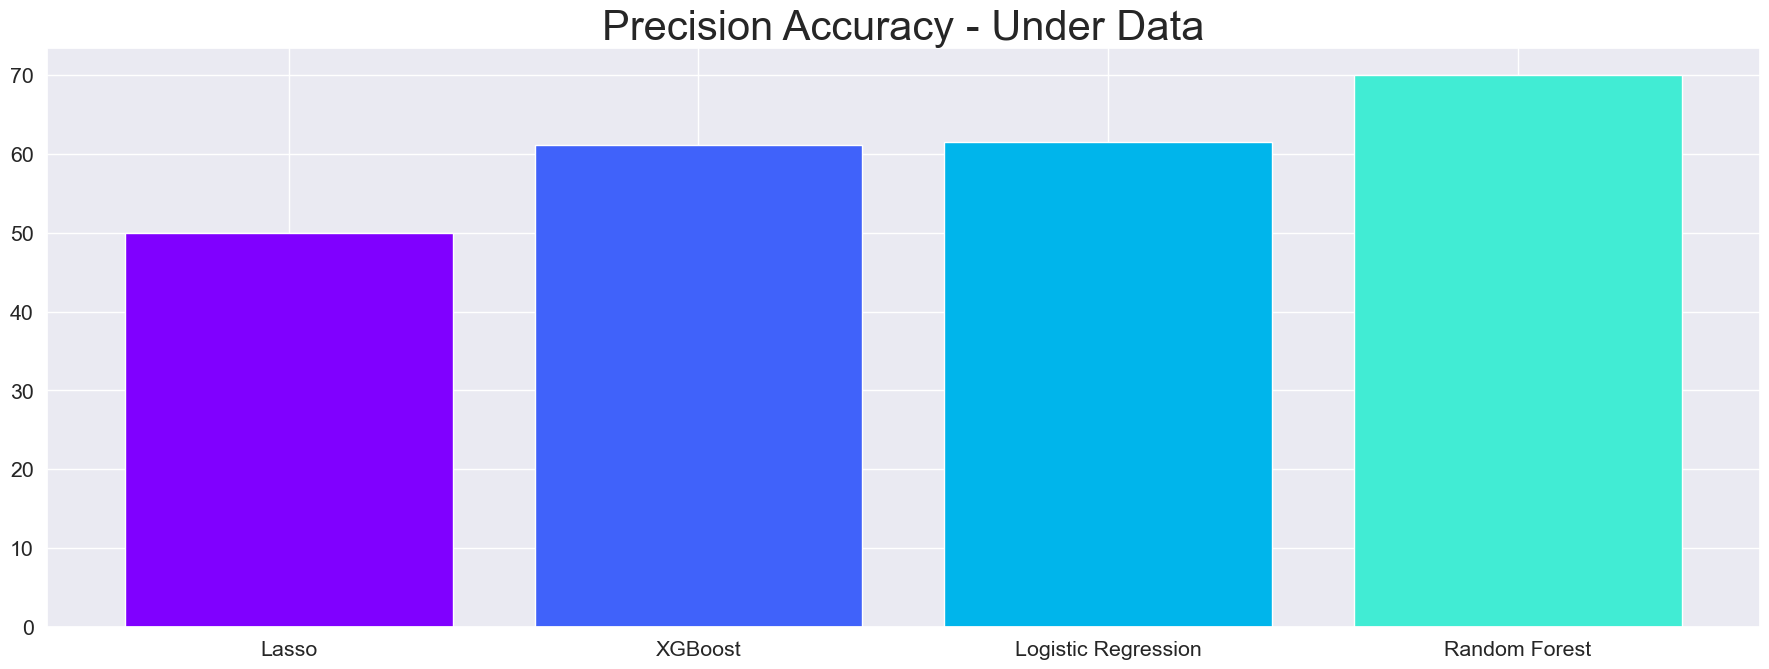

In [104]:
Recall = np.array([61.1,70,61.5,50])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("Precision Accuracy - Under Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

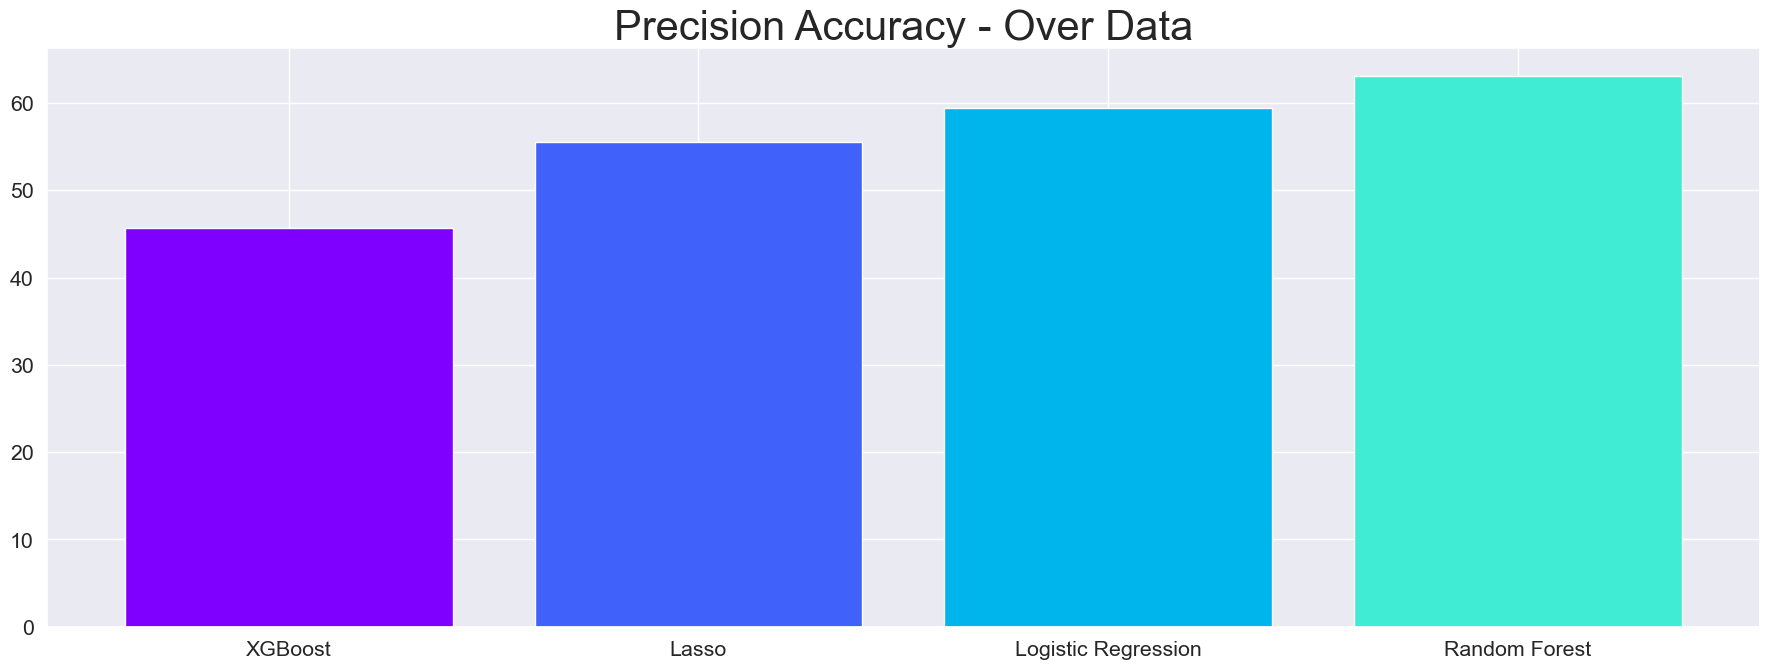

In [105]:
Recall = np.array([45.7,63.1,59.4,55.5])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("Precision Accuracy - Over Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

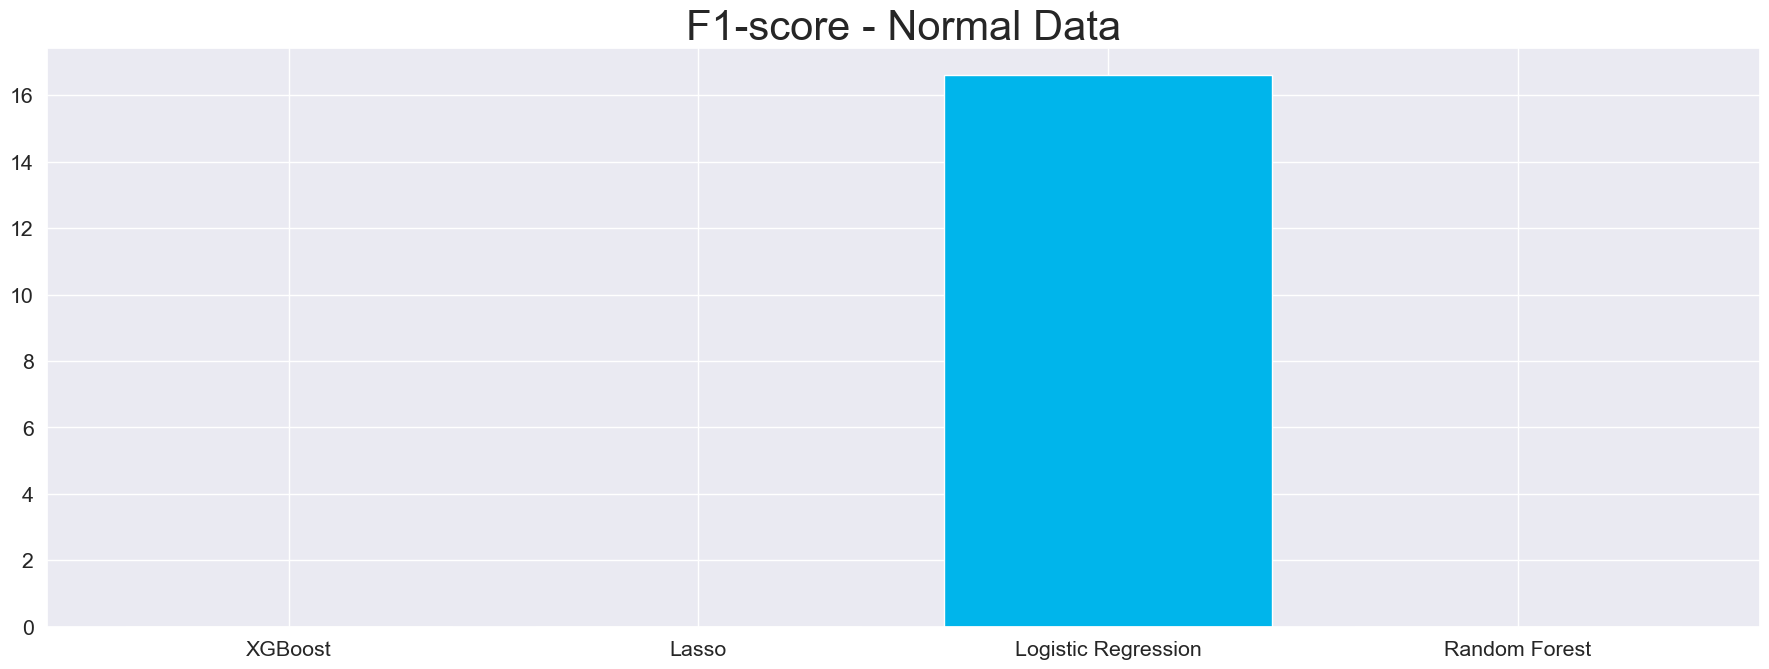

In [113]:
f1 = np.array([0,0,16.6,0])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), f1[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("F1-score - Normal Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

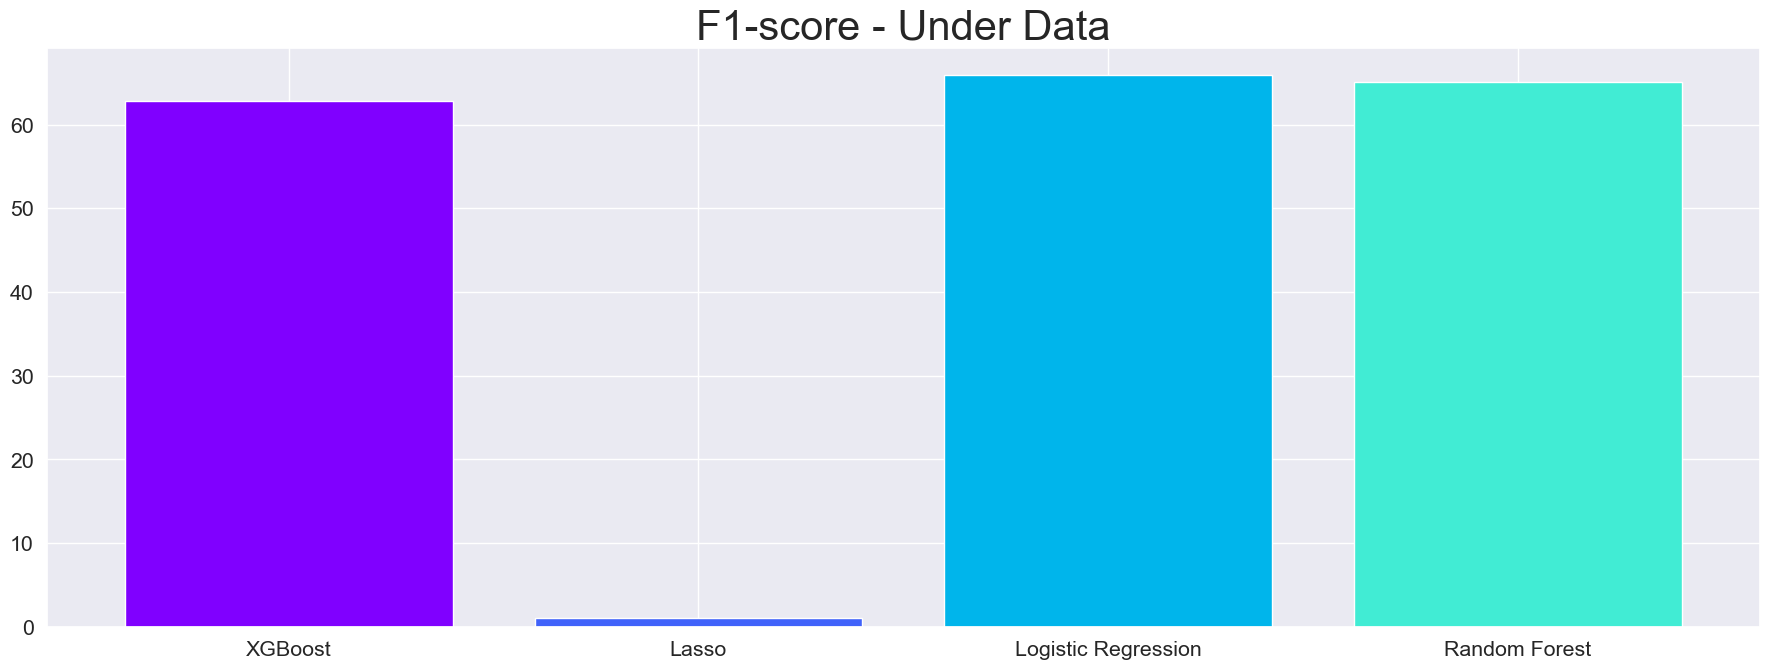

In [114]:
f1 = np.array([62.8,65.1,65.9,1])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), f1[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("F1-score - Under Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

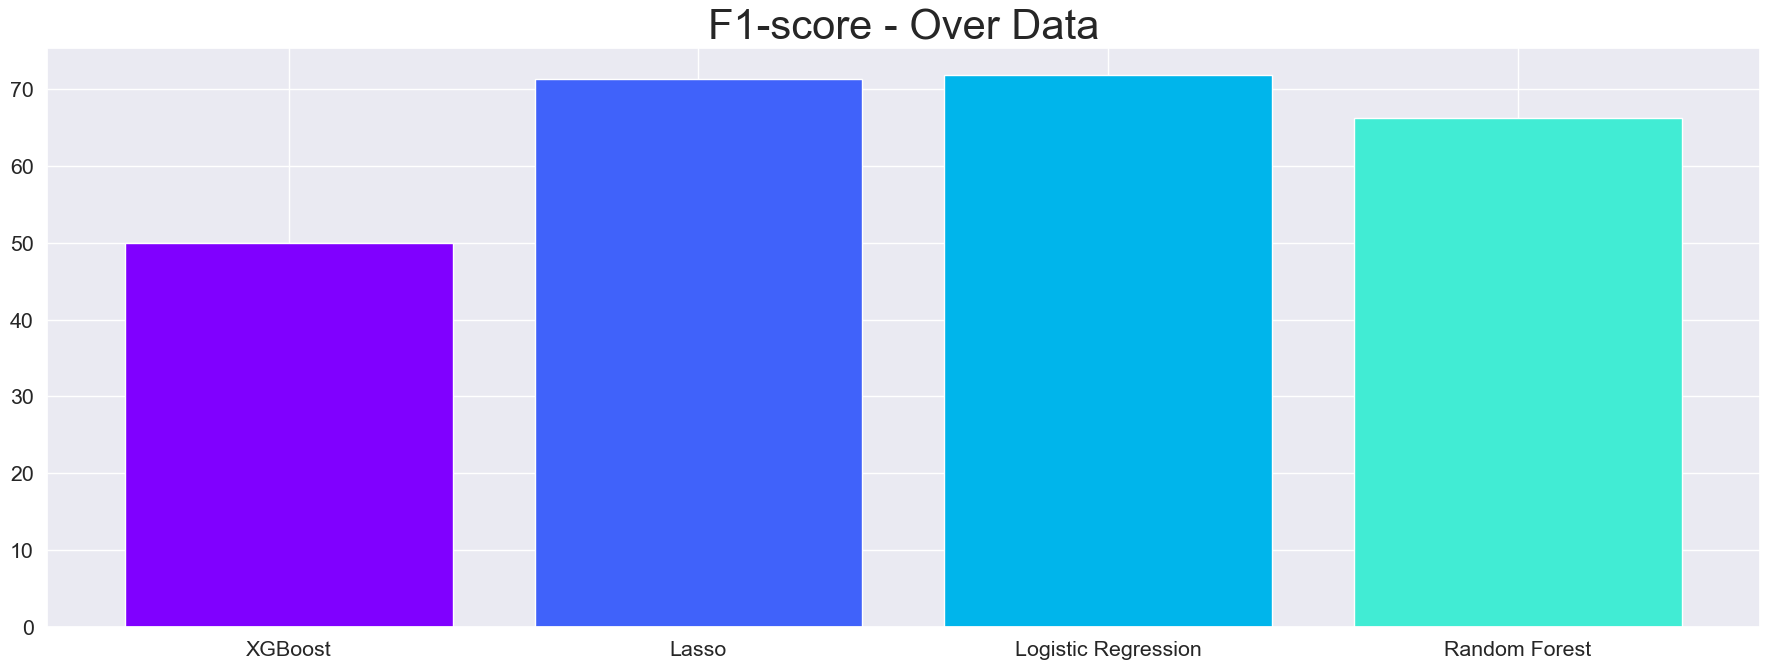

In [115]:
f1 = np.array([50,66.3,71.8,71.3])
label = np.array(['XGBoost','Random Forest','Logistic Regression','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), f1[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title("F1-score - Over Data", fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

<Figure size 8000x8000 with 0 Axes>

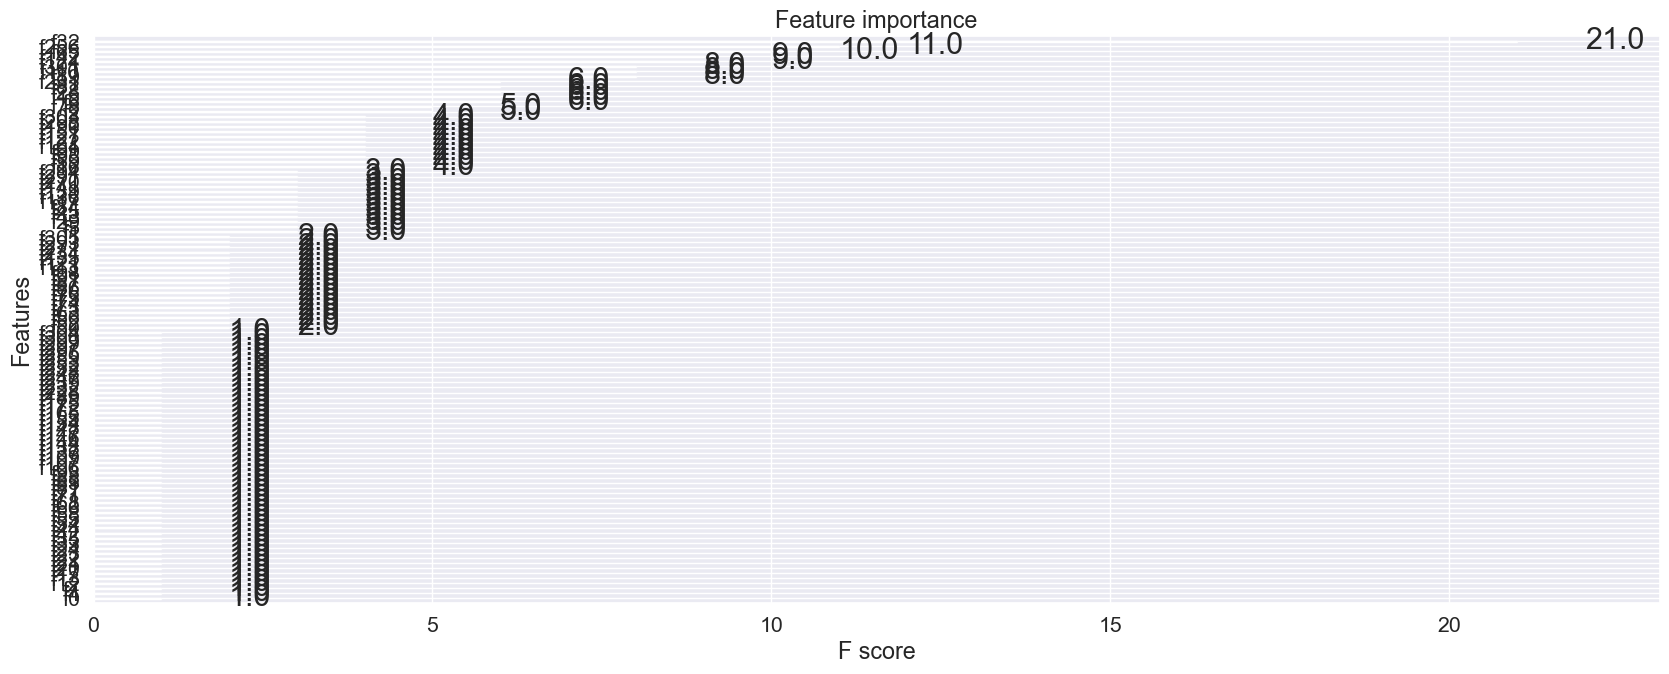

In [120]:
# plotting the feature importances

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
pyplot.rcParams.update({'font.size': 22})
from matplotlib.pyplot import figure
figure(num=None, figsize=(100,100), dpi=80, facecolor='w', edgecolor='k')
# fit model no training data
model = XGBClassifier()
model.fit(x_train_us, y_train_us)
# plot feature importance
plot_importance(model)
pyplot.show()

In [123]:
featureImp = []
for feat, importance in zip(data.columns, model.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False).head())


    Feature  Importance
81      126    4.005343
85      135    3.876802
28       45    3.154445
23       33    2.613102
239     460    2.608346


# 불균형 데이터 분류 모델 성능 비교 분석

## 1. 개요
다양한 분류 모델에 대해 **불균형 데이터 문제**를 해결하기 위한 실험을 진행하였습니다. 주요 모델로는 **XGBoost**, **Random Forest**, **Logistic Regression**, **Lasso**가 포함되었으며, 데이터 샘플링 방법으로 **언더샘플링**과 **오버샘플링**을 적용하였습니다. 각 모델의 성능은 **Accuracy**, **Recall**, **Precision**, **F1-score**를 기준으로 평가하였습니다.

---

## 2. 모델별 성능 요약

### 2.1 XGBoost
- **Normal (정상 데이터)**:
  - Accuracy: **93.2%**
  - Recall: **0**
  - Precision: **0**
- **Under (언더샘플링)**:
  - F1-score: **0.628**
- **Over (오버샘플링)**:
  - F1-score: **0.502**

### 2.2 Random Forest
- **Normal (정상 데이터)**:
  - Accuracy: **93.2%**
  - Recall: **0**
  - Precision: **0**
- **Under (언더샘플링)**:
  - F1-score: **0.652**
- **Over (오버샘플링)**:
  - F1-score: **0.664**

### 2.3 Logistic Regression
- **Normal (정상 데이터)**:
  - Accuracy: **90.6%**
  - Recall: **0.125**
  - Precision: **0.25**
  - F1-score: **0.167**
- **Under (언더샘플링)**:
  - F1-score: **0.657**
- **Over (오버샘플링)**:
  - F1-score: **0.719**

### 2.4 Lasso
- **Normal (정상 데이터)**:
  - Accuracy: **0**
  - Recall: **0**
  - Precision: **0**
  - F1-score: **0**
- **Under (언더샘플링)**:
  - F1-score: **0.020**
- **Over (오버샘플링)**:
  - Recall: **1**
  - Precision: **0.555**
  - F1-score: **0.714**

---

## 3. 샘플링 기법별 성능 분석

### 3.1 Normal (정상 데이터)
- 모든 모델에서 Accuracy는 높지만, Recall과 Precision은 매우 낮거나 **0**으로 불균형 문제 해결에 한계가 있음.

### 3.2 Under (언더샘플링)
- 샘플링으로 소수 클래스의 비율이 높아지면서 F1-score가 개선됨.
- Random Forest와 Logistic Regression에서 비교적 우수한 성능을 보임(F1-score: **0.65** 수준).

### 3.3 Over (오버샘플링)
- 대부분의 모델에서 가장 높은 성능을 기록.
- Logistic Regression이 F1-score **0.719**로 최상의 성능을 기록.

---

## 4. 결론 및 추천

1. **최고 성능 모델**:
   - Logistic Regression이 오버샘플링 환경에서 F1-score **0.719**로 가장 높은 성능을 기록하였음.
2. **샘플링 기법**:
   - 오버샘플링(SMOTE)이 언더샘플링 대비 전체적으로 더 나은 성능을 보였음.
3. **Lasso 모델**:
   - 대부분의 실험에서 낮은 성능을 기록하며 불균형 데이터 문제 해결에는 적합하지 않음.

---

## 5. 향후 개선 방향
- **Logistic Regression** 기반으로 추가적인 하이퍼파라미터 튜닝 및 데이터 전처리를 통해 성능을 더욱 개선 가능.
- **Random Forest** 및 **XGBoost**에서도 추가적인 실험을 통해 성능 향상을 도모할 여지가 있음.
- **특성 중요도(Feature Importance)** 분석을 통해 주요 변수(예: 81번, 85번, 28번 변수)를 활용한 모델 최적화를 고려.

---

위 결과를 바탕으로, Logistic Regression과 SMOTE 기반의 데이터 증강이 현재 데이터셋에서 가장 효과적인 접근법으로 판단됩니다.